Notebook to simulate 1D diffusion utilizing 
random walk methodology. Used to validate modal markov formulation for calcium
diffusion. Simple 1d diffusion with no reactions.

11 nodes.

author: Margot Wagner
date created: 6/16/22
Updated: 10/13/22: split apart diffusion functions from RandomWalk1DEigenmodeDecomposi

### setup

In [6]:
import numpy as np
from numpy.linalg import eig
import matplotlib.pyplot as plt
import math
from typing import Union, Tuple

In [7]:
# constants
# create mesh
n_spatial_locs = 11  # define number of grid points along 1D line
dt = 1  # time step (usec)
n_time_pts = 1000  # number of time points

particle_start_loc = 5  # starting position for molecules
min_loc = 0  # minimum position
max_loc = n_spatial_locs - 1  # maximum position
last_elem_i = -1  # index for the last element in a list

line_length = 4  # total length of diffusion line (um)
n_particles = 50  # number of molecules
diffusion_constant_D = 2.20e-4  # Calcium diffusion coeff (um^2/usec)

### 1D Random Walk Diffusion Simulation

(implementation similar to GeeksforGeeks' ["Random Walk (Implementation in Python)"](https://www.geeksforgeeks.org/random-walk-implementation-python/))

#### Probability of jumping left/right

Rate constant: $k = \frac{D}{dx^2}$

$P(jumping) = kdt$

<div>
<img src="figures/get_jump_probability.svg" width="500"/>
</div>

In [8]:
def get_jump_probability(
    line_length: Union[int,float], 
    n_spatial_locs: int, 
    diffusion_constant_D: float, 
    dt: Union[int,float]
) -> Tuple[float, float]:
    """Find the probability of moving one spot to the left or right based on 
    finite-difference approximations

    params:
        line_length:
            length of line on which molecule is diffusing
        n_spatial_locs:
            number of locations molecule can diffuse to
        diffusion_constant_D:
            calcium diffusion constant
        dt:
            time step

    return:
        - probability of diffusing one spot to the left or right (k*dt)
        - k: diffusion rate constant

    """
    dx = line_length / n_spatial_locs  # distance of one "hop"
    diffusion_rate_constant_k = diffusion_constant_D / dx**2  # rate constant

    return diffusion_rate_constant_k * dt, diffusion_rate_constant_k

In [9]:
def random_walk_simulation(n_particles: int, 
                           n_time_pts: int, 
                           jump_probability: float
                           ) -> np.ndarray:
    """1-D random walk for n_particles from a range of 
    positions = [0, (n_spatial_locs - 1)]

    Args:
      n_particles:
        total number of molecules
      n_time_pts:
        number of time points
      jump_probability:
        probability of particle diffusing to neighboring grid point

    Returns:
      positions of all particles over time - matrix shaped 
        (n_particles, n_time_pts)
    """

    # probabilities depending on if particle is in middle or at edge
    jump_probability_middle = [
        jump_probability,
        1 - 2 * jump_probability,
        jump_probability,
    ]
    jump_probability_edge = [jump_probability, 1 - jump_probability]

    # initialize array for all particle positions (number of particles)
    particle_locs = np.empty((n_particles, n_time_pts), dtype="int64")

    for n in range(n_particles):

        # Initialize starting position (0 to (n_spatial_locs - 1) range)
        positions = [particle_start_loc]

        # sampling probability all at once (1000 timepoints)
        rand = np.random.random(n_time_pts - 1)

        # movement decision conditions
        move_l_cond = rand < jump_probability
        move_r_cond = rand > (1 - jump_probability)
        # stay condition is between the two

        # run simulation for particle n
        # check probability rolls
        for move_left, move_right in zip(move_l_cond, move_r_cond):

            # move left if move_left=True and last position != minimum 
            # position 
            left = move_left and positions[last_elem_i] > min_loc

            # move right if move_right=True and last position != maximum 
            # position 
            right = move_right and positions[last_elem_i] < max_loc

            # stay condition is implied

            # adjust position accordingly
            positions.append(positions[last_elem_i] - left + right)

        # add results to cumulative array
        particle_locs[n] = positions

    return particle_locs

In [10]:
def random_walk_postprocess(
  particle_locs: np.ndarray, 
  plot=False
  ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Post-process 1D random-walk diffusion 
    (counts, normalized counts, means)

    Args:
      particle_locs:
        positions of all particles over time - matrix shaped 
        (n_particles, n_time_pts)

    Returns:
      unnorm_n_per_loc:
        number of particles in each position over time (unnormalized)
      n_per_loc:
        number of particles in each position over time (normalized)
      mean_n_per_loc:
        mean value of particle number at each location over the whole 
        simulation
    """

    # distribution of particles across positions over time
    unnorm_n_per_loc = np.zeros(
        (n_spatial_locs, n_time_pts), dtype="int64"
    )  # number of particles over time
    
    n_per_loc = np.zeros(
        (n_spatial_locs, n_time_pts)
    )  # normalized count over time

    for i in range(n_time_pts):
        # count number of particles in each position
        counts = np.bincount(particle_locs[:, i])

        # resize to include all positions if it doesn't already
        counts.resize(n_spatial_locs)

        # assign number of particles
        unnorm_n_per_loc[:, i] = counts

        # normalize counts and assign
        counts = counts / particle_locs.shape[0]
        n_per_loc[:, i] = counts

    mean_n_per_loc = np.mean(unnorm_n_per_loc, axis=1)

    if plot:
        # plot particle counts for each position
        plt.figure(figsize=(14, 10))

        for i in range(n_spatial_locs):
            plt.plot(list(range(n_time_pts)), n_per_loc[i, :])

        plt.title(
            "Normalized number of particles in each position over time",
            fontsize=20,
        )
        plt.xlabel("timepoint", fontsize=14)
        plt.ylabel("normalized count", fontsize=14)
        plt.legend(list(range(n_spatial_locs)))
        plt.show()

    return unnorm_n_per_loc, n_per_loc, mean_n_per_loc

### Main

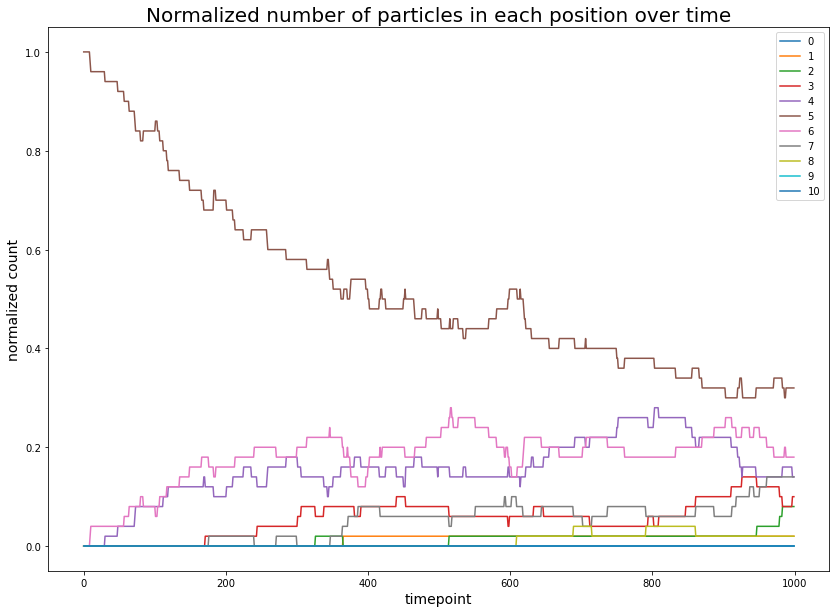

In [12]:
def main():

    # find probability of moving one step
    jump_probability, jump_rate_constant_k = get_jump_probability(
        line_length, n_spatial_locs, diffusion_constant_D, dt
    )

    # run simulation
    particle_locs = random_walk_simulation(
        n_particles, n_time_pts, jump_probability
    )

    # plot output
    unnorm_n_per_loc, n_per_loc, mean_n_per_loc = random_walk_postprocess(
        particle_locs, plot=True
    )

if __name__ == "__main__":
    tables_created = main()